Import necessary packages

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import datasets and packages

In [12]:
df_lookup = pd.read_csv('../../data/raw/EXTR_LookUp.csv', dtype='str')
df_parcel = pd.read_csv('../../data/raw/EXTR_PARCEL.csv', dtype='str')
df_resbldg = pd.read_csv('../../data/raw/EXTR_ResBldg.csv', dtype='str')
df_rpsale = pd.read_csv('../../data/raw/EXTR_RPSale.csv', dtype='str')

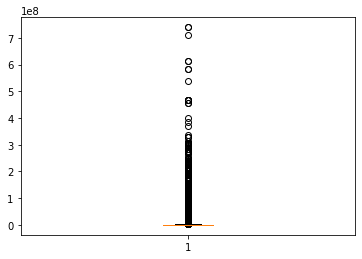

In [38]:
df_rpsale = pd.read_csv('../../data/raw/EXTR_RPSale.csv')
price = df_rpsale.SalePrice

plt.boxplot(price);

In [59]:
def remove_extremes(data, devct):
    cleaned = data.loc[data>0].copy()

    std = cleaned.std()
    med = cleaned.median()

    cleaned = cleaned.loc[(cleaned > (med - std*devct)) & (cleaned < (med+std*devct))].copy() 
    return cleaned

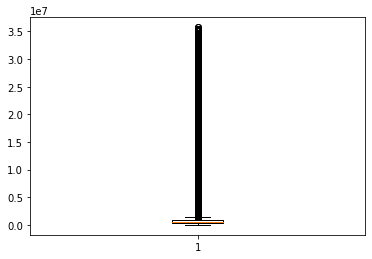

In [65]:
price = remove_extremes(df_rpsale.SalePrice, 3)
#price.hist();
plt.boxplot(price);